<a href="https://colab.research.google.com/github/Shehab37/gans/blob/main/pytorch_dcgan_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c generative-dog-images
! mkdir dogs
! unzip -r generative-dog-images.zip -d dogs

In [ ]:
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:

! kaggle competitions download -c generative-dog-images


In [ ]:
! unzip all-dogs.zip -d dogs

In [ ]:
!unzip Annotation.zip -d dog-annotations

Archive:  Annotation.zip
replace dog-annotations/Annotation/n02097658-silky_terrier/n02097658_98? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
from tqdm.auto import tqdm

import datetime
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras import layers
import tensorflow as tf
import time

In [ ]:
pics = []
dogs_path = "/content/dogs/all-dogs"
for path in os.listdir(dogs_path):
    if '.jpg' in path:
        pics.append(os.path.join(dogs_path, path))

In [ ]:
print(len(pics))
# new_path=path_celeb[0:50000]
# print(len(new_path))
# path_celeb = []

20579


In [ ]:
plt.imshow(Image.open(pics[4444]))

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(150, 150),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
aug_ds = []
for pic in pics:

  image = Image.open(pic)
  aug_ds.append(resize_and_rescale(np.array(image), training=True))
  
aug_ds = np.array(aug_ds) 
aug_ds = aug_ds.reshape(aug_ds.shape[0], 150, 150, 3).astype('float32')
print(aug_ds.shape)

(20579, 150, 150, 3)


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

In [ ]:
batch_size = 32
lr = 0.001
beta1 = 0.5
epochs = 300

real_label = 0.5
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [ ]:
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='/content/dogs/all-dogs',
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

                                           
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


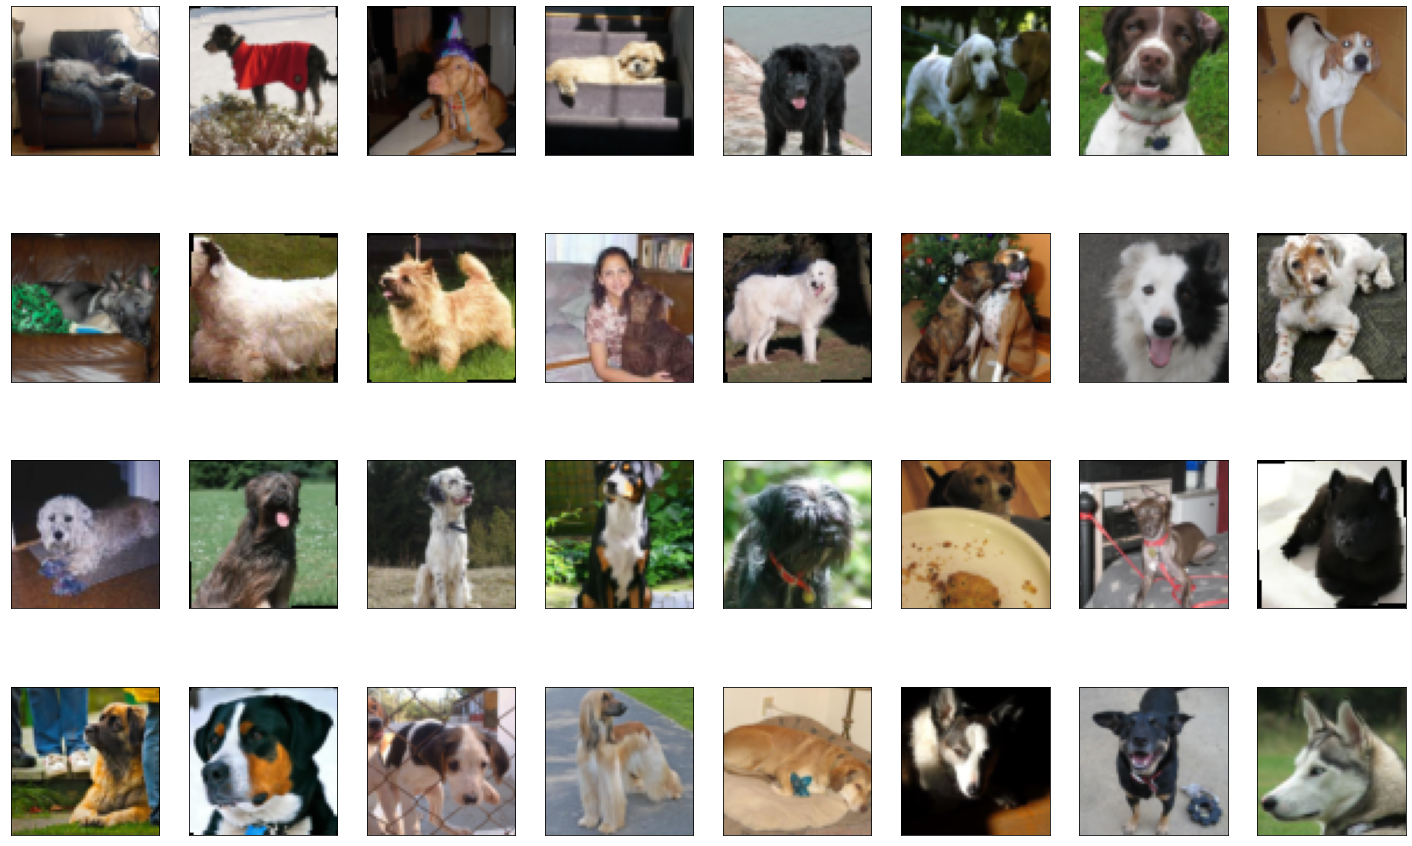

In [ ]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

In [ ]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

In [ ]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.imshow((gen_image+1)/2)
    plt.show()

In [ ]:
for epoch in range(epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        
        netG.zero_grad()
        outputF = netD(fake)   
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        optimizerG.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))

    show_generated_img()

In [ ]:
for epoch in range(epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)



        fake = netG(noise)
        outputF = netD(fake)   


        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))

    show_generated_img()

In [ ]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

In [ ]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

In [ ]:
if not os.path.exists('/output_images'):
    os.mkdir('/output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('/output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '/output_images')